# Processing Data where LLMs were asked directly 

Starting Point:

Goal:


In [200]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pingouin as pg


In [201]:
# load data
def load_dataframes(path = "LLM_data/ask_directly_outputs/"):

    # Initialize empty list to store DataFrames
    dataframe = []

    path = path  # folder with CSVs of LLM answers
    #print(glob.glob(os.path.join(path, f"*_Outline_ask_LLM_models_directly_results.csv")))
    for file in glob.glob(os.path.join(path, f"*_Outline_ask_LLM_models_directly_results.csv")):
        
        model_name = os.path.basename(file).replace(f"*_Outline_ask_LLM_models_directly_results.csv", "")
        #print(model_name)
        # Read the CSV
        df = pd.read_csv(file)
        
        # Append to list
        dataframe.append(df)
        
    # Concatenate all DataFrames into one big DataFrame
    merged_data = pd.concat(dataframe, ignore_index=True)

    print(f"Merged DataFrame shape: {merged_data.shape}")
    print(f"Total models: {merged_data['model'].nunique()}")

    return(merged_data)

LLM_data = load_dataframes(path = "LLM_data/ask_directly_outputs/")

Merged DataFrame shape: (9632, 18)
Total models: 43


### Add categories for DOSPERT and revert flipped answers

In [202]:
# Adding task specific categories to save in all data

# add item categories
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

mask = LLM_data["experiment"] == "DOSPERT scale"

LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)

In [203]:
LLM_data[LLM_data["experiment"] == "DOSPERT scale"]

,model,experiment,type,flipped,item,question,model_answer,logprob_1,logprob_2,logprob_3,logprob_4,logprob_5,logprob_6,logprob_7,logprob_8,logprob_9,logprob_10,logprob_11,category
68,gemma-2-2b-it,DOSPERT scale,survey,no,1,Admitting that your tastes are different from ...,3.0,-3.921875,-2.296875,-0.925781,-0.925781,-6.25000,NaN,NaN,NaN,NaN,NaN,NaN,Social
69,gemma-2-2b-it,DOSPERT scale,survey,no,2,"Going camping in the wilderness, beyond the ci...",4.0,-2.343750,-1.085938,-2.843750,-4.093750,-7.46875,NaN,NaN,NaN,NaN,NaN,NaN,Recreational
70,gemma-2-2b-it,DOSPERT scale,survey,no,3,Betting a day's income at the horse races.,4.0,-2.406250,-2.156250,-3.281250,-5.031250,-6.21875,NaN,NaN,NaN,NaN,NaN,NaN,Gambling
71,gemma-2-2b-it,DOSPERT scale,survey,no,4,Buying an illegal drug for your own use.,1.0,-2.046875,-3.796875,-4.187500,-4.562500,-4.06250,NaN,NaN,NaN,NaN,NaN,NaN,Health
72,gemma-2-2b-it,DOSPERT scale,survey,no,5,Cheating on an exam.,3.0,-0.613281,-3.484375,-3.609375,-4.500000,-9.06250,NaN,NaN,NaN,NaN,NaN,NaN,Ethical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9551,Qwen3-1.7B,DOSPERT scale,survey,yes,36,Exposing yourself to the sun without using sun...,1.0,-46.750000,-47.000000,-47.750000,-45.000000,-45.25000,NaN,NaN,NaN,NaN,NaN,NaN,Health
9552,Qwen3-1.7B,DOSPERT scale,survey,yes,37,Trying out bungee jumping at least once.,4.0,-46.750000,-47.000000,-47.750000,-45.000000,-45.00000,NaN,NaN,NaN,NaN,NaN,NaN,Recreational
9553,Qwen3-1.7B,DOSPERT scale,survey,yes,38,"Piloting your own small plane, if you could.",4.0,-46.500000,-46.750000,-47.750000,-44.750000,-45.00000,NaN,NaN,NaN,NaN,NaN,NaN,Recreational
9554,Qwen3-1.7B,DOSPERT scale,survey,yes,39,Walking home alone at night in a somewhat unsa...,4.0,-47.000000,-47.250000,-48.000000,-45.250000,-45.50000,NaN,NaN,NaN,NaN,NaN,NaN,Health


In [204]:
# flip back human answers where they were flipped
mask = (LLM_data["experiment"] == "DOSPERT scale") & (LLM_data["flipped"] == "yes")
LLM_data.loc[mask, "model_answer"] = 6 - LLM_data.loc[mask, "model_answer"]


### Add categories for SOEP scale and revert flipped answers

In [205]:
# add item categories
item_to_category = {
     1: "SOEP", 2: "SOEPdri", 3: "SOEPfin",  4: "SOEPrec", 5: "SOEPocc",  6: "SOEPhea",  7: "SOEPsoc"
}
mask = LLM_data["experiment"] == "SOEP scale"
LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)

In [206]:
# flip back human answers where they were flipped
mask = (LLM_data["experiment"] == "DOSPERT scale") & (LLM_data["flipped"] == "yes")
LLM_data.loc[mask, "model_answer"] = 12 - LLM_data.loc[mask, "model_answer"]



### Process BARRAT scale

In [207]:
# flip back model answers where they were flipped
mask = (LLM_data["experiment"] == "BARRAT scale") & (LLM_data["flipped"] == "True")
LLM_data.loc[mask, "model_answer"] = 5 - LLM_data.loc[mask, "model_answer"]


In [208]:
# Adding task specific categories to save in all data

# add item categories
item_to_category = {
    1: "BISn", 2: "BISm", 3: "BISm",  4: "BISm", 5: "BISa",  6: "BISa",  7: "BISn",  8: "BISn",  9: "BISa",  10: "BISn",
    11: "BISa", 12: "BISn", 13: "BISn",  14: "BISn", 15: "BISn",  16: "BISm",  17: "BISm",  18: "BISn",  19: "BISm",  20: "BISa",
    21: "BISm", 22: "BISm", 23: "BISm",  24: "BISa", 25: "BISm",  26: "BISa",  27: "BISn",  28: "BISa",  29: "BISn",  30: "BISm"
}
# add whether item was reverse coded
reverse_coded = {
    1: True, 2: False, 3: False,  4: False, 5: False,  6: False,  7: True,  8: True,  9: True,  10: True,
    11: False, 12: True, 13: True,  14: False, 15: True,  16: False,  17: False,  18: False,  19: False,  20: True,
    21: False, 22: False, 23: False,  24: False, 25: False,  26: False,  27: False,  28: False,  29: True,  30: True
    }
mask = LLM_data["experiment"] == "BARRAT scale"

LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)
LLM_data.loc[mask, "reverse_coded"] = LLM_data.loc[mask, "item"].map(reverse_coded)


In [209]:
# flip back answers that where reverse coded
mask = (LLM_data["experiment"] == "BARRAT scale") & (LLM_data["reverse_coded"] == True)
LLM_data.loc[mask, "model_answer"] = 5 - LLM_data.loc[mask, "model_answer"]
# drop reverse-coded column (not needed in final data)
LLM_data = LLM_data.drop(columns=["reverse_coded"])


### Process SSSV scale

In [210]:
# for q in sssv["question"].head(40):
#     print(f"1: {q}")

In [211]:
# flip back human answers where they were flipped
mask = (LLM_data["experiment"] == "SSSV scale") & (LLM_data["flipped"] == "True")
LLM_data.loc[mask, "model_answer"] = 3 - LLM_data.loc[mask, "model_answer"]


In [212]:
# Adding task specific categories to save in all data

# add item categories
item_to_category = {
     3: "SStas", 11: "SStas", 16: "SStas", 17: "SStas", 20: "SStas", 21: "SStas", 23: "SStas", 28: "SStas", 38: "SStas", 40: "SStas",
     4: "SSexp", 6: "SSexp", 9: "SSexp", 10: "SSexp", 14: "SSexp", 18: "SSexp", 19: "SSexp", 22: "SSexp", 26: "SSexp", 37: "SSexp",
     1: "SSdis", 12: "SSdis", 13: "SSdis", 25: "SSdis", 29: "SSdis", 30: "SSdis", 32: "SSdis", 33: "SSdis", 35: "SSdis", 36: "SSdis",
     2: "SSbor", 5: "SSbor", 7: "SSbor", 8: "SSbor", 15: "SSbor", 24: "SSbor", 27: "SSbor", 31: "SSbor", 34: "SSbor", 39: "SSbor"
}

reverse_coded = {
     1: True, 2: False, 3: True, 4: False, 5: True, 6: True, 7: False, 8: True, 9: True, 10: False, 
     11: False, 12: False, 13: False, 14: True, 15: False, 16: True, 17: True, 18: True, 19: False, 20: False,
     21: False, 22: True, 23: True, 24: True, 25: False, 26: False, 27: False, 28: True, 29: True, 30: False,
     31: False, 32: True, 33: False, 34: True, 35: False, 36: True, 37: False, 38: False, 39: True, 40: False

}

mask = LLM_data["experiment"] == "SSSV scale"

LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)
LLM_data.loc[mask, "reverse_coded"] = LLM_data.loc[mask, "item"].map(reverse_coded)

# flip back answers that where reverse coded
# mask = (LLM_data["experiment"] == "SSSV scale") & (LLM_data["reverse_coded"] == True)
# LLM_data.loc[mask, "model_answer"] = 3 - LLM_data.loc[mask, "model_answer"]
# drop reverse-coded column (not needed in final data)
LLM_data = LLM_data.drop(columns=["reverse_coded"])


## Reliability Analysis

In [213]:
# function:
def compute_cronbach_alpha(score = "model_answer"):
    results = []

    # loop through experiments
    for exp, exp_data in LLM_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))

alpha_df = compute_cronbach_alpha()


In [214]:
alpha_df

,experiment,domain,alpha,alpha_CI
0,BARRAT scale,BISa,0.684289,"[0.519, 0.809]"
1,BARRAT scale,BISm,0.743456,"[0.613, 0.844]"
2,BARRAT scale,BISn,0.807740,"[0.71, 0.883]"
3,DOSPERT scale,Ethical,0.938192,"[0.906, 0.963]"
4,DOSPERT scale,Gambling,0.900488,"[0.841, 0.941]"
5,DOSPERT scale,Health,0.923604,"[0.883, 0.954]"
6,DOSPERT scale,Investment,0.874313,"[0.799, 0.926]"
7,DOSPERT scale,Recreational,0.944660,"[0.916, 0.967]"
8,DOSPERT scale,Social,0.918384,"[0.876, 0.951]"
9,Decisions From Description,total,0.784722,"[0.672, 0.87]"


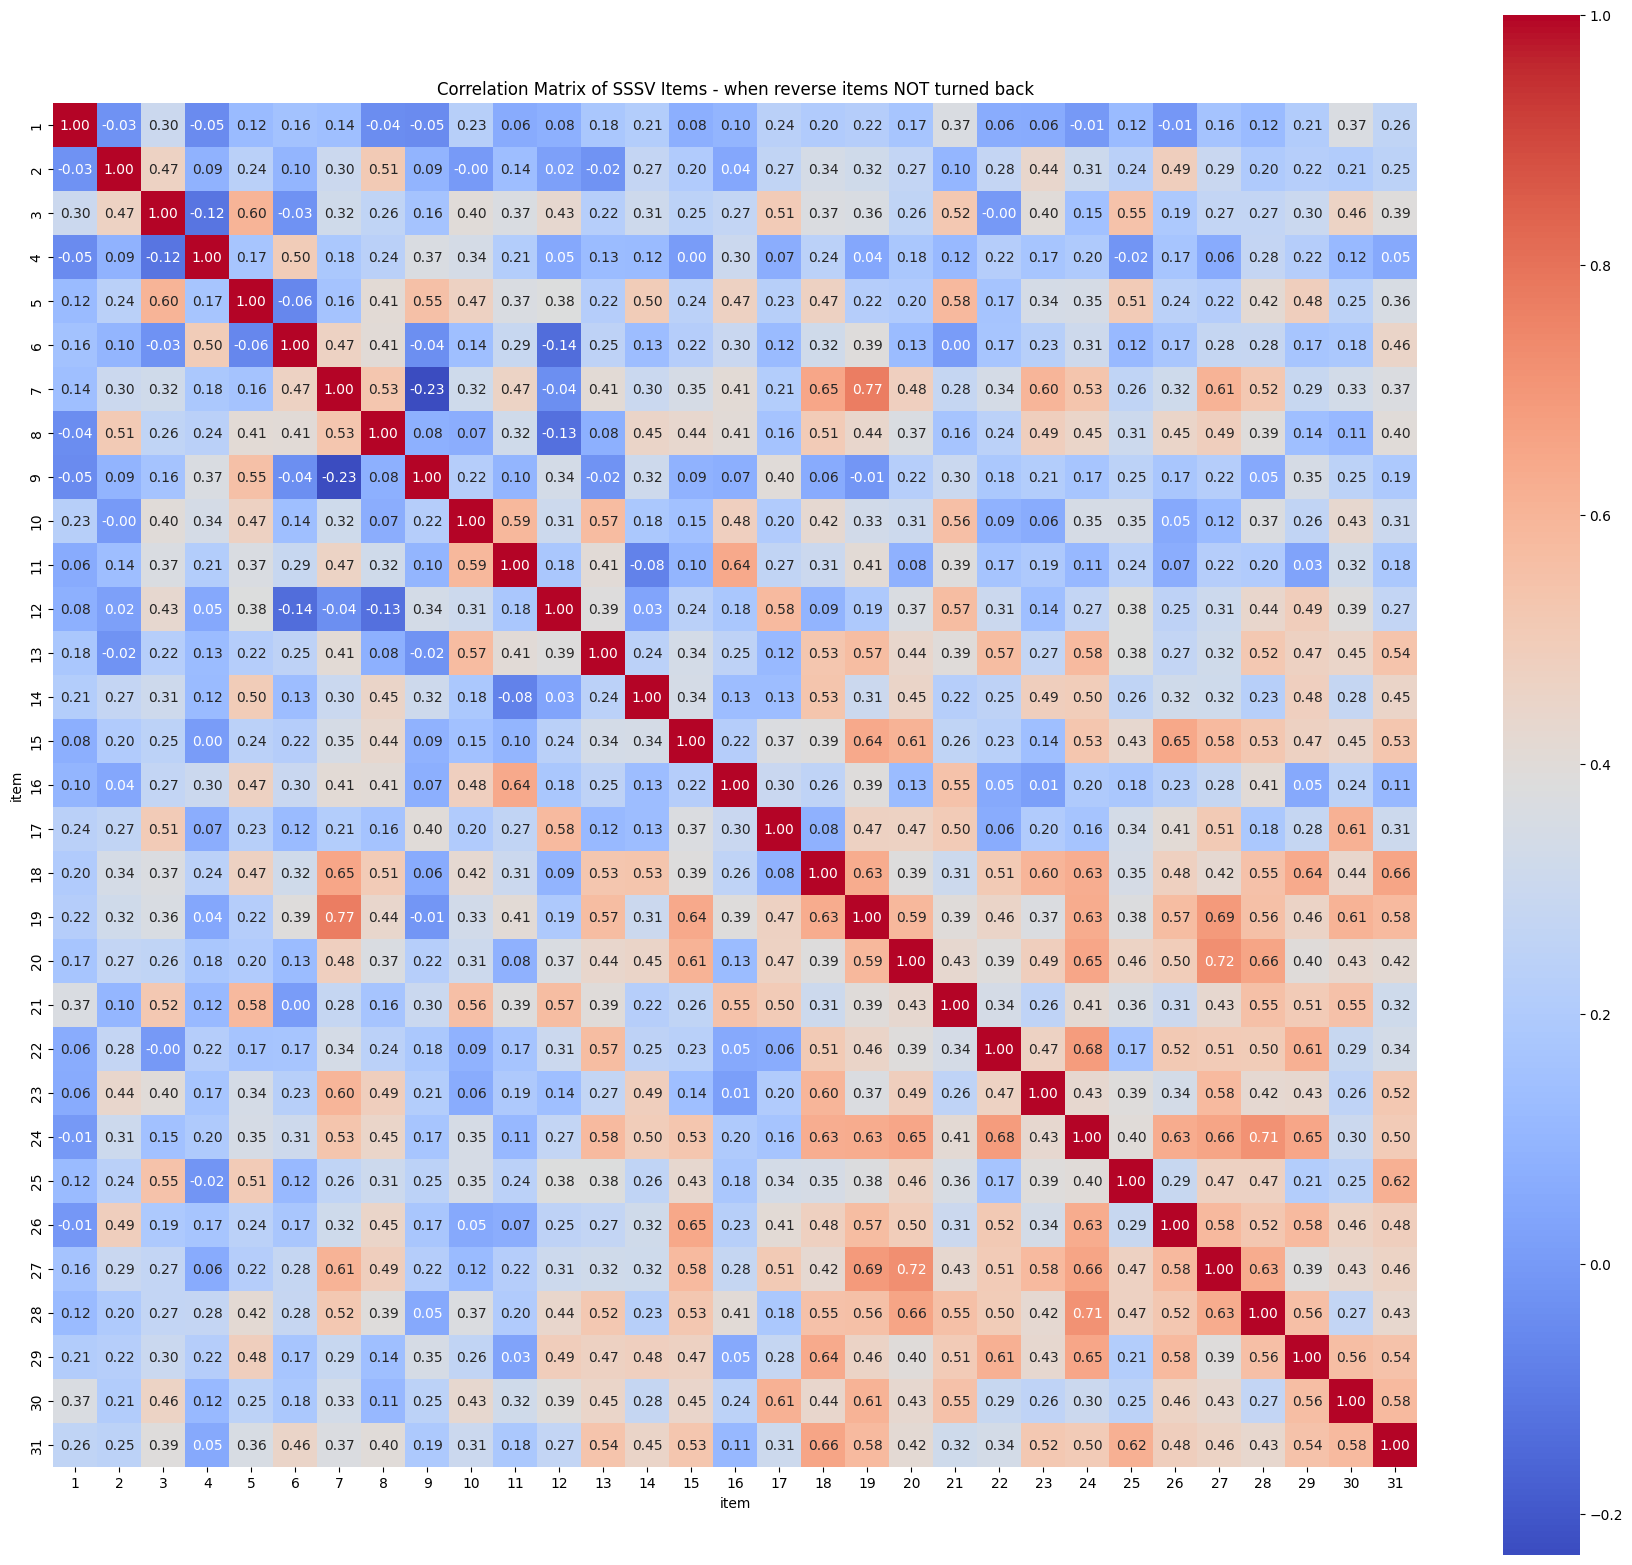

In [84]:
sssv = LLM_data[LLM_data["experiment"] == "SSSV scale"]
sssv_wide = sssv.pivot_table(
    index="model",  
    columns="item",
    values="model_answer"
)
corr_matrix = sssv_wide.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of SSSV Items - when reverse items NOT turned back")
plt.show()

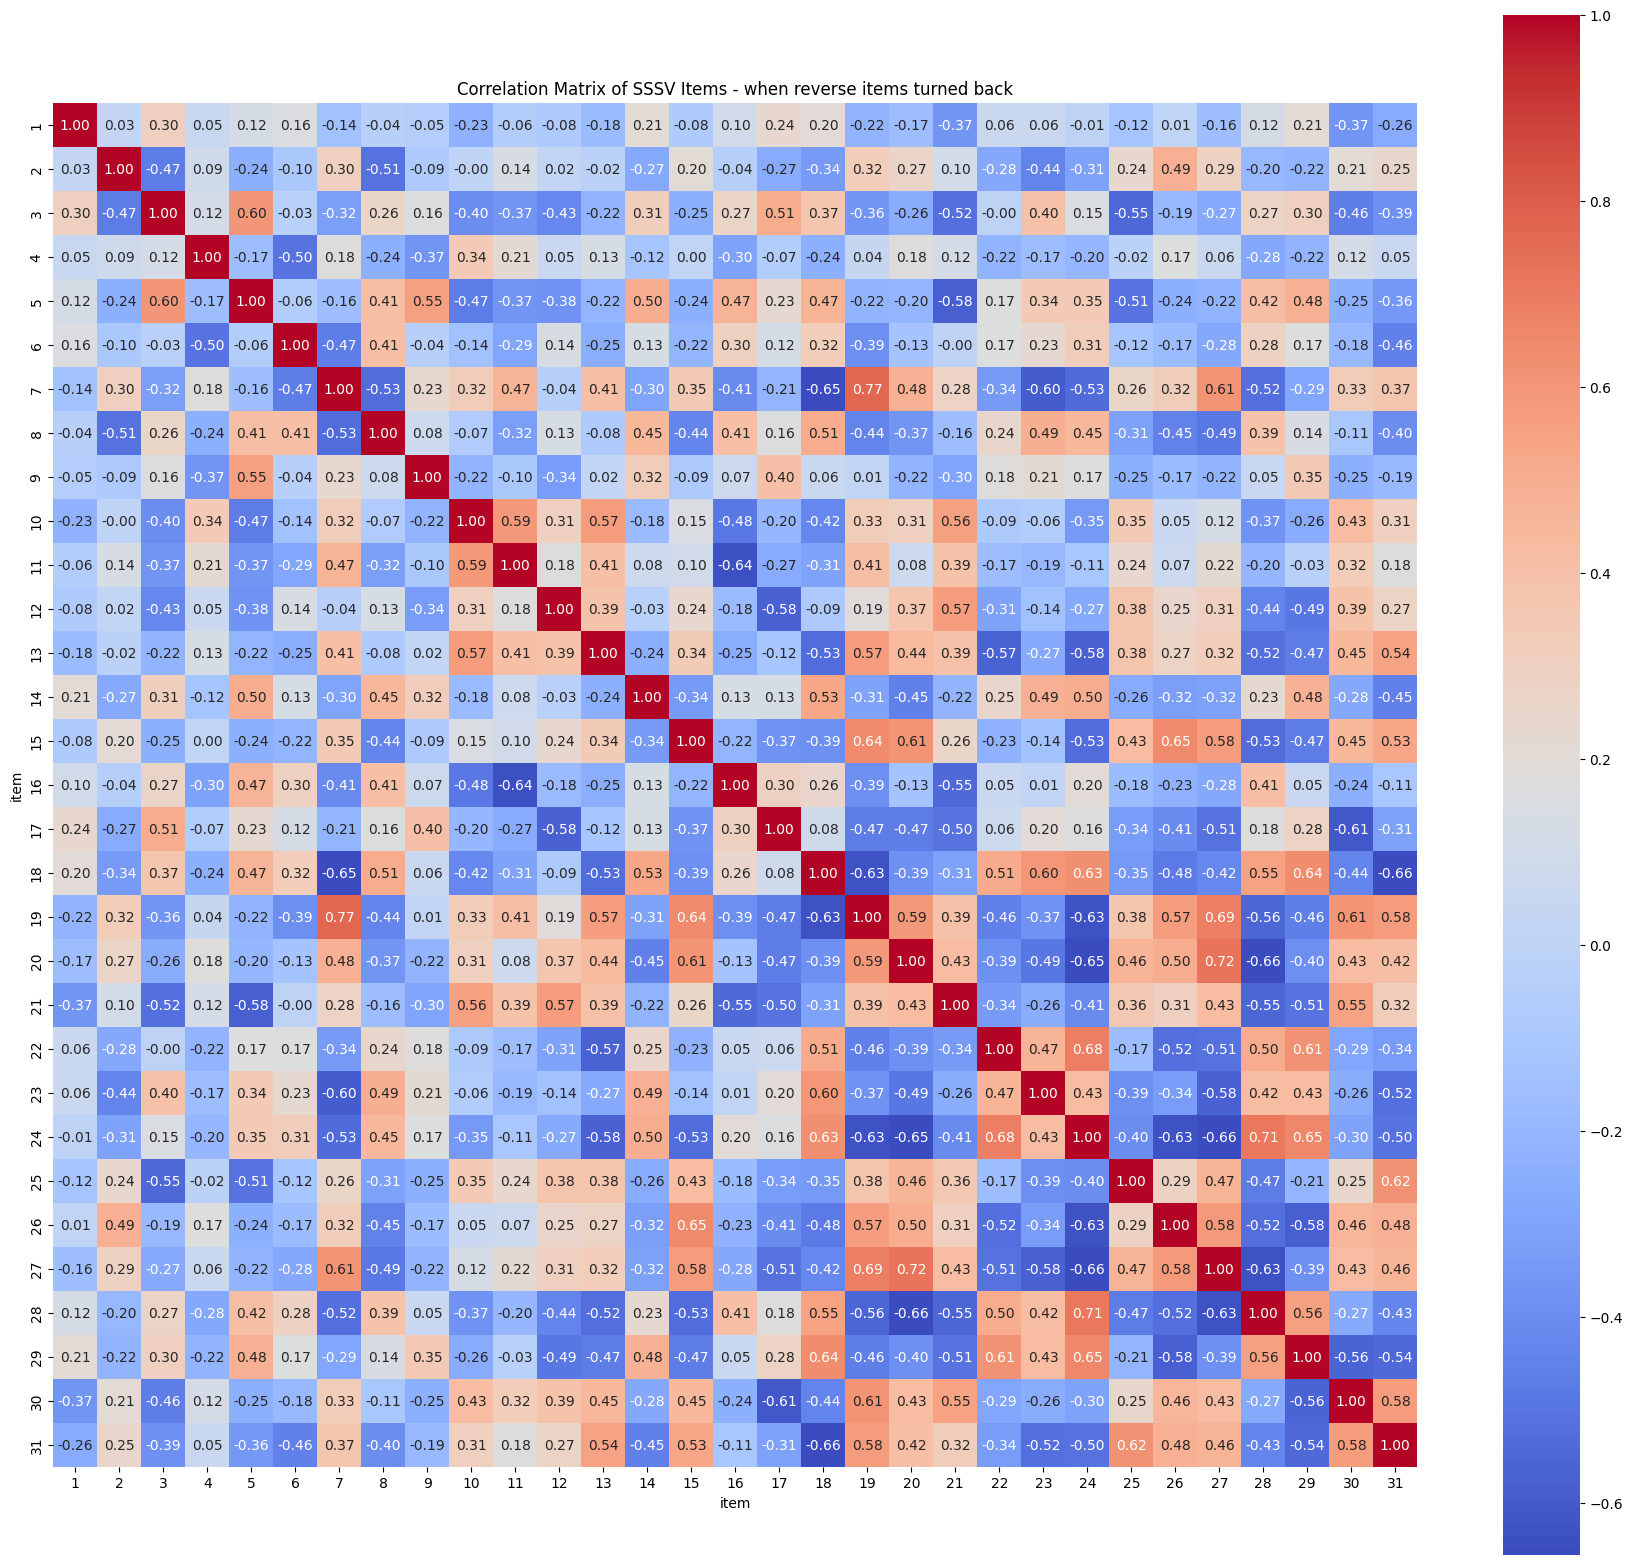

In [74]:
sssv = LLM_data[LLM_data["experiment"] == "SSSV scale"]
sssv_wide = sssv.pivot_table(
    index="model",  
    columns="item",
    values="model_answer"
)
corr_matrix = sssv_wide.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of SSSV Items - when reverse items turned back")
plt.show()


## Correlations within LLM output data

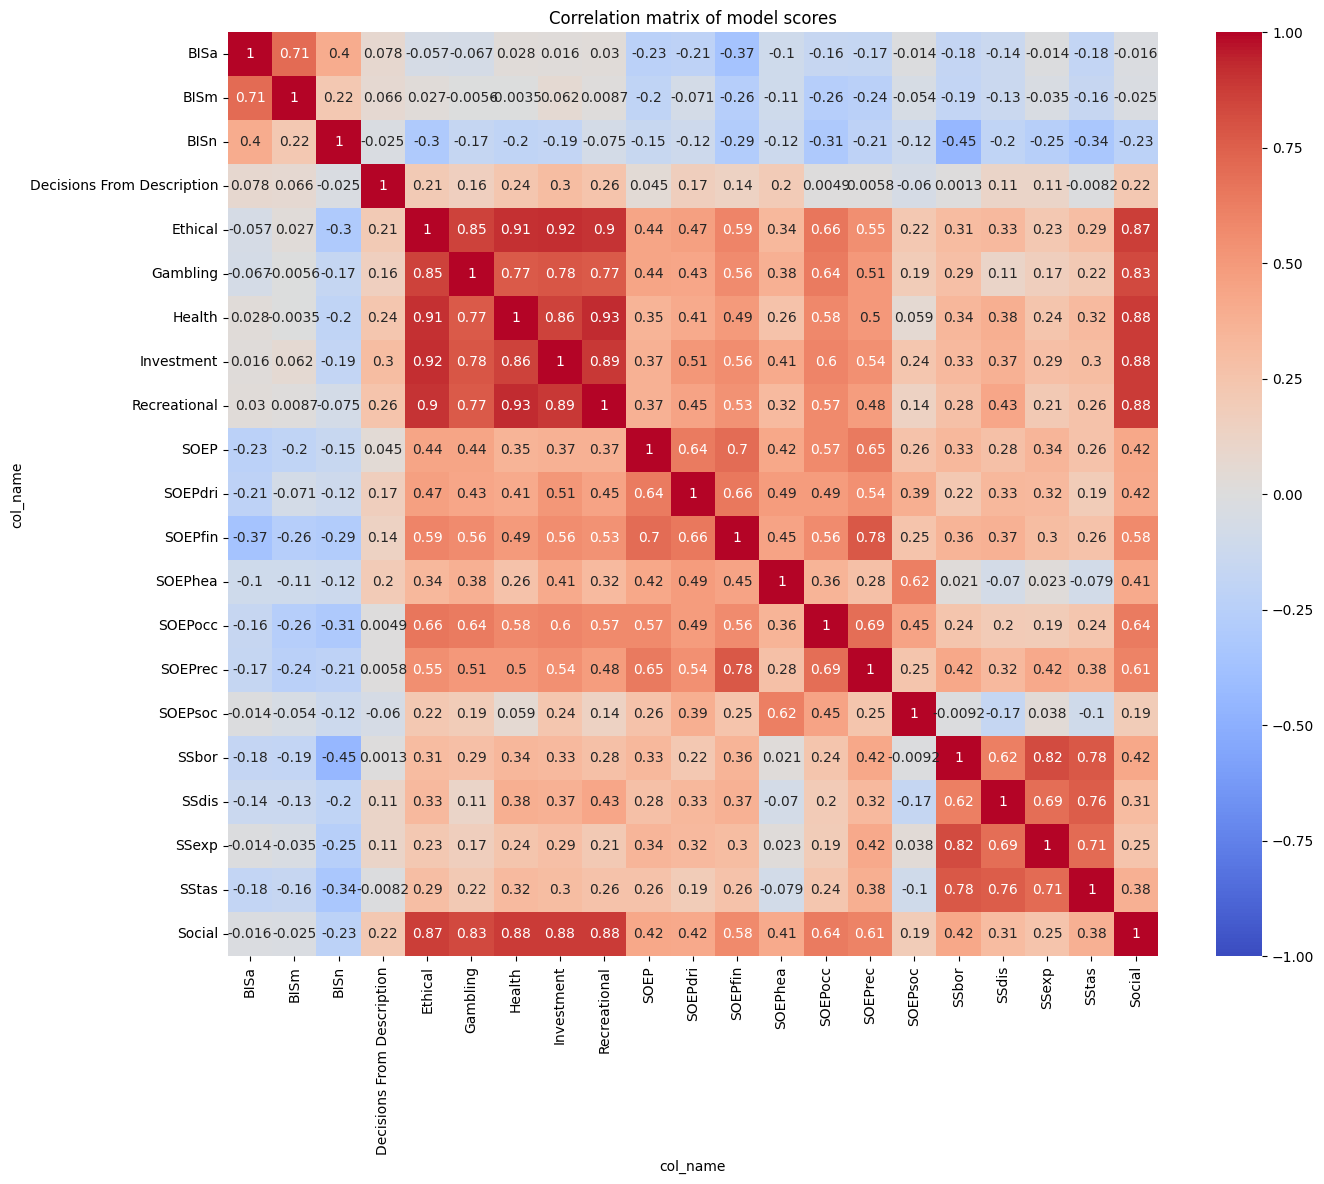

In [215]:
# get df in wide format
LLM_data["col_name"] = LLM_data["category"].fillna(LLM_data["experiment"])
data_wide = LLM_data.pivot_table(
    index="model",  
    columns="col_name",
    values="model_answer"
)
corr_matrix = data_wide.corr()
# Display it as a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores")
plt.show()


In [148]:
data_wide

col_name,BISa,BISm,BISn,Decisions From Description,Ethical,Gambling,Health,Investment,Recreational,SOEP,...,SOEPfin,SOEPhea,SOEPocc,SOEPrec,SOEPsoc,SSbor,SSdis,SSexp,SStas,Social
model,,,,,,,,,,,,,,,,,,,,,
Apertus-8B-Instruct-2509,2.500000,2.545455,2.500000,1.000000,1.0000,1.500,1.3750,1.000,1.062500,1.0,...,1.0,1.0,1.0,1.0,1.0,1.562500,1.500000,1.500000,1.500000,1.250000
Falcon-3-10B-Instruct,1.812500,1.681818,1.545455,1.000000,2.9375,3.000,3.0000,2.875,3.000000,7.0,...,6.0,4.0,7.0,8.0,4.0,1.937500,1.833333,1.722222,1.750000,2.812500
Falcon-3-1B-Instruct,1.625000,1.681818,2.454545,1.000000,1.0000,1.000,1.0000,1.250,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.500000,1.500000,1.500000,1.500000,1.000000
Falcon-3-7B-Instruct,1.937500,2.181818,1.818182,1.000000,2.9375,2.500,2.9375,2.500,2.937500,6.0,...,6.5,3.0,5.0,7.0,2.0,1.937500,1.750000,1.666667,1.812500,3.000000
LFM2-1.2B,2.125000,1.818182,2.909091,1.000000,1.0000,1.750,1.0000,1.000,1.375000,8.0,...,1.0,1.0,5.0,4.0,1.0,1.500000,1.500000,1.500000,1.500000,1.375000
LFM2-2.6B,2.250000,2.363636,1.863636,1.875000,3.7500,3.750,3.6250,2.875,3.687500,7.0,...,4.0,5.0,5.5,5.0,5.0,2.000000,1.916667,2.000000,2.000000,3.250000
LFM2-8B-A1B,2.500000,2.409091,2.409091,1.875000,1.0000,1.500,1.1875,1.000,1.125000,7.0,...,4.0,1.0,1.0,4.0,1.0,1.687500,1.583333,1.611111,1.687500,1.750000
Llama-3.1-8B-Instruct,1.375000,1.954545,1.409091,1.375000,2.5000,3.000,1.5625,2.500,1.812500,6.0,...,5.0,6.5,7.5,4.5,5.5,1.562500,1.250000,1.388889,1.500000,2.937500
Llama-3.2-1B-Instruct,2.500000,2.500000,2.500000,1.125000,1.0000,1.000,1.0000,1.000,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.500000,1.500000,1.500000,1.500000,1.000000


In [ ]:
# Compute correlation matrix (only for numeric columns)
corr = all_data[["score_BART", "score_CCT", "score_DFD", "score_DFE", "score_LOT", "score_MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores")
plt.show()


## Correlations same task LLM outputs versus human-LLM data